# Sentiment Analysis for Amazon Product Reviews

# **I. Train dataset from Amazon**

## **A. Data Analysis**

In [1]:
# Install the following modules initially
#!pip install spacy
#!python -m spacy download en_core_web_md
#nltk.download('punkt')

In [2]:
# Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score

### **A.1 Loading the dataset**

In [9]:
df = pd.read_csv('amazon_reviews.csv')
df.head()

,Label,Review
0,positive,Stuning even for the non-gamer: This sound tra...
1,positive,The best soundtrack ever to anything.: I'm rea...
2,positive,Amazing!: This soundtrack is my favorite music...
3,positive,Excellent Soundtrack: I truly like this soundt...
4,positive,"Remember, Pull Your Jaw Off The Floor After He..."


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   Label   1048538 non-null  object
 1   Review  1044134 non-null  object
dtypes: object(2)
memory usage: 16.0+ MB


In [11]:
# Drop the samples with missing data
df.dropna(inplace=True)
df.head()

,Label,Review
0,positive,Stuning even for the non-gamer: This sound tra...
1,positive,The best soundtrack ever to anything.: I'm rea...
2,positive,Amazing!: This soundtrack is my favorite music...
3,positive,Excellent Soundtrack: I truly like this soundt...
4,positive,"Remember, Pull Your Jaw Off The Floor After He..."


In [12]:
# Lets use only the top 500K for faster processing
df1 = df[:500000]
df1

,Label,Review
0,positive,Stuning even for the non-gamer: This sound tra...
1,positive,The best soundtrack ever to anything.: I'm rea...
2,positive,Amazing!: This soundtrack is my favorite music...
3,positive,Excellent Soundtrack: I truly like this soundt...
4,positive,"Remember, Pull Your Jaw Off The Floor After He..."
...,...,...
502053,negative,Yuck!: The girls in this specific video are RE...
502054,positive,Hi-Fi - Hugh Cornwell: Certainly well worth a ...
502055,negative,Black and White Illustrations: Do you want a b...
502056,positive,Brown thumb to green- brown yard to rainbow of...


In [13]:
import warnings
warnings.filterwarnings("ignore")

df1 = df1[(df['Label']=='positive ') | (df['Label']=='negative ')]
df1['Label'].replace({'positive ':'positive', 'negative ':'negative'}, inplace=True)
df1.reset_index(inplace=True)
del df1['index']
df1

,Label,Review
0,positive,Stuning even for the non-gamer: This sound tra...
1,positive,The best soundtrack ever to anything.: I'm rea...
2,positive,Amazing!: This soundtrack is my favorite music...
3,positive,Excellent Soundtrack: I truly like this soundt...
4,positive,"Remember, Pull Your Jaw Off The Floor After He..."
...,...,...
499926,negative,Yuck!: The girls in this specific video are RE...
499927,positive,Hi-Fi - Hugh Cornwell: Certainly well worth a ...
499928,negative,Black and White Illustrations: Do you want a b...
499929,positive,Brown thumb to green- brown yard to rainbow of...


## **B. Data Preparation**

In [14]:
# Split the data
#train_set, test_set, y_train, y_test = train_test_split(df['Review'], df['Label'], test_size = 0.3, random_state=12)
train_set, test_set, y_train, y_test = train_test_split(df1['Review'], df1['Label'], test_size = 0.3, random_state=12)

In [15]:
# Transform Reviews text into a sparse matrix of n-gram counts by initiatlizing CountVectorizer
reviews_vector = CountVectorizer(min_df=2, tokenizer=nltk.word_tokenize, max_features=2000) # use top 2000 words only

# fit and transform the training_set
train_set_counts = reviews_vector.fit_transform(train_set)

In [16]:
# Check the shape of counts data
train_set_counts.shape

(349951, 2000)

In [17]:
# Convert raw frequency counts into TF-IDF values
reviews_tfidf = TfidfTransformer()
train_set_tfidf = reviews_tfidf.fit_transform(train_set_counts)

In [18]:
# Check the shape of tfidf data
train_set_tfidf.shape

(349951, 2000)

In [19]:
# Transform test data using fitted vectorizer and transformer
test_set_counts = reviews_vector.transform(test_set)
test_set_tfidf = reviews_tfidf.transform(test_set_counts)

In [20]:
# Scale train and test data
from sklearn.preprocessing import MaxAbsScaler

scaler = MaxAbsScaler()
train_set_tfidf = scaler.fit_transform(train_set_tfidf)
test_set_tfidf = scaler.fit_transform(test_set_tfidf)

## **C. Model build**

#### **Multinomial Naive Bayes**

In [21]:
# Now, we can build our classifier. We will use Multinomial Naive Bayes
# The multinomial Naive Bayes classifier is suitable for classification with discrete features (e.g., word counts for text classification). 
# It normally requires integer feature counts. However, in practice, fractional counts such as tf-idf may also work.

nb = MultinomialNB()
nb.fit(train_set_tfidf, y_train)

MultinomialNB()

In [22]:
# Predict the test result and print accuracy
y_pred_nb = nb.predict(test_set_tfidf)
accuracy = accuracy_score(y_test, y_pred_nb)
print("Multinomial Naive Bayes Accuracy : {}".format(accuracy))

Multinomial Naive Bayes Accuracy : 0.844439258567809


#### **Logistic Regression**

In [23]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(solver = 'liblinear', random_state = 42, max_iter=2000)
lr.fit(train_set_tfidf, y_train)

LogisticRegression(max_iter=2000, random_state=42, solver='liblinear')

In [24]:
# Predict the test reult and print accuracy
y_pred_lr = lr.predict(test_set_tfidf)
accuracy = accuracy_score(y_test, y_pred_lr)
print("Linear Regression Accuracy : {}".format(accuracy))

Linear Regression Accuracy : 0.8828710494732631


#### **Random Forrest**

In [25]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(max_depth=2, random_state=0, max_features=2000)
rf.fit(train_set_tfidf, y_train)

RandomForestClassifier(max_depth=2, max_features=2000, random_state=0)

In [26]:
# Predict the test reult and print accuracy
y_pred_rf = rf.predict(test_set_tfidf)
accuracy = accuracy_score(y_test, y_pred_rf)
print("Random Forrest Accuracy : {}".format(accuracy))

Random Forrest Accuracy : 0.6375783437791706


#### **Linear Support Vector Machine (SVM)**

In [27]:
from sklearn.svm import LinearSVC

svm = LinearSVC(random_state=0, max_iter=2000)
svm.fit(train_set_tfidf, y_train)

LinearSVC(max_iter=2000, random_state=0)

In [28]:
# Predict the test reult and print accuracy
y_pred_svm = svm.predict(test_set_tfidf)
accuracy = accuracy_score(y_test, y_pred_svm)
print("Support Vector Machine Accuracy : {}".format(accuracy))

Support Vector Machine Accuracy : 0.8828110414721962


#### **Saving Models**

In [29]:
import pickle
classifier_saver = open('Naive_Bayes.plk', 'wb')
pickle.dump(nb, classifier_saver)
classifier_saver.close()

classifier_saver = open('Logistic_regression.plk', 'wb')
pickle.dump(lr, classifier_saver)
classifier_saver.close()

classifier_saver = open('SVM.plk', 'wb')
pickle.dump(svm, classifier_saver)
classifier_saver.close()

### **Result**

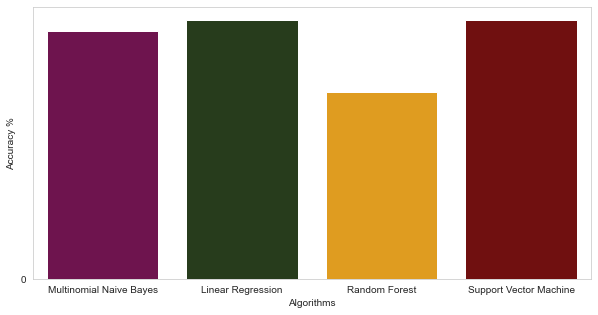

In [30]:
# Comparing Models
accuracies = {}

accuracies['Multinomial Naive Bayes']=accuracy_score(y_test, y_pred_nb)
accuracies['Linear Regression']=accuracy_score(y_test, y_pred_lr)
accuracies['Random Forest']=accuracy_score(y_test, y_pred_rf)
accuracies['Support Vector Machine']=accuracy_score(y_test, y_pred_svm)

colors = ["#7D0552", "#254117", "#FFA500", "#800000","#CFC60E","#0FBBAE"]

sns.set_style("whitegrid")
plt.figure(figsize=(10,5))
plt.yticks(np.arange(0,100,10))
plt.ylabel("Accuracy %")
plt.xlabel("Algorithms")
sns.barplot(x=list(accuracies.keys()), y=list(accuracies.values()), palette=colors)
plt.show()

### **Validation**

In [31]:
# Let's try to test the model on a sample review
my_review = ['The movie was excellent', 'It was trash', 'I love it', 'It was childish']
my_review_counts = reviews_vector.transform(my_review)
my_review_tfidf = reviews_tfidf.transform(my_review_counts)
my_review_tfidf = scaler.fit_transform(my_review_tfidf)

In [32]:
# Uncomment the classifier that you want to test

pred = nb.predict(my_review_tfidf) 
#pred = lr.predict(my_review_tfidf) 
#pred = rf.predict(my_review_tfidf) 
#pred = svm.predict(my_review_tfidf) 

In [33]:
for review, pred in zip(my_review, pred):
  print('%r is %s' % (review, pred))

'The movie was excellent' is positive
'It was trash' is negative
'I love it' is positive
'It was childish' is negative


# **II. Analyze Twitter data**

## **A. Data Analysis and pre-processing**

In [39]:
# importing required libraries
import spacy
import unicodedata
import re
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
import en_core_web_md
# from contractions import CONTRACTION_MAP
import unicodedata
nltk.download('all')

tokenizer = ToktokTokenizer()
stopword_list = nltk.corpus.stopwords.words('english')
stopword_list.remove('no')
stopword_list.remove('not')
nlp = en_core_web_md.load()
#nlp = spacy.load('en_core_web_md', parse=True, tag=True, entity=True)

pd.set_option('display.max_colwidth', 1000)

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     C:\Users\madse\AppData\Roaming\nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     C:\Users\madse\AppData\Roaming\nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     C:\Users\madse\AppData\Roaming\nltk_data...
[nltk_data]    |   Package biocreative_ppi is already up-to-date!
[nltk_data]    | Downloading package brown to
[nltk_data]    |     C:\Users\madse\AppData\Roaming\nltk_data...
[nltk_data]    |   Package brown is already up-to-date!
[nltk_data]    | Downloading package brown_tei to
[nltk_data]    |     C:\Users\madse\AppData\Roaming\nltk_data...
[nltk_data]    |   Package brown_tei is already up-to-date!
[nltk_data]    | Downloading package cess_cat to
[nltk_data]    |     C:\Users\m

In [40]:
# Function to clean twitter data
import re
def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text

def lemmatize_text(text):
    text = nlp(text)
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text

def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text


def normalize_corpus(corpus, accented_char_removal=True, text_lower_case=True, 
                     text_lemmatization=True, special_char_removal=True, 
                     stopword_removal=True, remove_digits=True):
    
    doc = corpus
    # accented characters removal
    if accented_char_removal:
      doc = remove_accented_chars(doc)
    
    # lowercase text
    if text_lower_case:
        doc = doc.lower()
    
    doc = re.sub(r'[\r|\n|\r\n]+', ' ',doc)
    
    # lemmatize text
    if text_lemmatization:
      doc = lemmatize_text(doc)
    
    # remove special characters and\or digits    
    if special_char_removal:
        # insert spaces between special characters to isolate them    
        special_char_pattern = re.compile(r'([{.(-)!}])')
        doc = special_char_pattern.sub(" \\1 ", doc)
        doc = remove_special_characters(doc, remove_digits=remove_digits)  
    
    # remove extra whitespace
    doc = re.sub(' +', ' ', doc)
    
    # remove stopwords
    if stopword_removal:
        doc = remove_stopwords(doc, is_lower_case=text_lower_case)
            
        
    return doc


def clean_tweets(text):
  # removing words starting with @ or #
  doc = re.sub(r'@[a-zA-Z0-9]+', "", text)
  doc = re.sub(r'#[a-zA-Z0-9]+', "", doc)
  doc = re.sub(r'https://t.co/[a-zA-Z0-9]+', '', doc, flags=re.MULTILINE)
  doc = re.sub(r'[\W_]', ' ', doc) # removing underscores
  doc = re.sub(r'(http(s:|:)\/\/)(www.|WWW.)+([0-9a-z.A-Z-]\.\w{2,3})', '', doc, flags=re.MULTILINE)
  doc = normalize_corpus(doc, text_lemmatization=False)
  return doc

In [42]:
# Loading twitter dataset
df_tw = pd.read_csv('twitter_amazon.csv')
df_tw.head()

,tweet_id,tweet_location,tweet_time,user_id,text
0,1380301062075256838,South Africa,2021-04-08 23:26:32,965302152800407553,The Science of Success \n\nhttps://t.co/5uYJg4e1qq\n\n#amazon #AmazonQuiz #amazonposition #AmazonPrimeVideo #AmazonUnion #Amazonプライムビデオ #AmazonPrime #AmazonReview #Amazonギフト券 #AmazonWishList #ad\nhttps://t.co/xLM2OrqHBd
1,1380268812759666690,"Vancouver, BC",2021-04-08 21:18:23,147223992,RT @SuccessAnalytiX: The Science of Success \n\nhttps://t.co/5uYJg4e1qq\n\n#amazon #AmazonQuiz #amazonposition #AmazonPrimeVideo #AmazonUnion #…
2,1380267869217431556,South Africa,2021-04-08 21:14:38,965302152800407553,The Science of Success \n\nhttps://t.co/5uYJg4e1qq\n\n#amazon #AmazonQuiz #amazonposition #AmazonPrimeVideo #AmazonUnion #Amazonプライムビデオ #AmazonPrime #AmazonReview #Amazonギフト券 #AmazonWishList #ac\nhttps://t.co/xLM2OrqHBd
3,1380204289918910469,"Portland, OR",2021-04-08 17:02:00,2435815254,"Curious if coding is right for you, but not sure where to start? Learn the basics of JavaScript in one weekend with our Learn Coding Basics with JavaScript book!\n\nPurchase your copy here: https://t.co/VCLfrCGER8\n\n#learncoding #learntocode #codingbook #amazonreview #bookreview https://t.co/gpFWhniTE3"
4,1380204088927907844,"Salt Lake City, Utah",2021-04-08 17:01:12,1184207030241779712,"Curious if coding is right for you, but not sure where to start? Learn the basics of JavaScript in one weekend with our Learn Coding Basics with JavaScript book!\n\nPurchase your copy here: https://t.co/tof0RsvrTY\n\n#learncoding #learntocode #codingbook #amazonreview #bookreview https://t.co/vuryvSMEAn"


In [43]:
# creating a subset
df_text = df_tw.iloc[:,[1, 4]]
df_text

,tweet_location,text
0,South Africa,The Science of Success \n\nhttps://t.co/5uYJg4e1qq\n\n#amazon #AmazonQuiz #amazonposition #AmazonPrimeVideo #AmazonUnion #Amazonプライムビデオ #AmazonPrime #AmazonReview #Amazonギフト券 #AmazonWishList #ad\nhttps://t.co/xLM2OrqHBd
1,"Vancouver, BC",RT @SuccessAnalytiX: The Science of Success \n\nhttps://t.co/5uYJg4e1qq\n\n#amazon #AmazonQuiz #amazonposition #AmazonPrimeVideo #AmazonUnion #…
2,South Africa,The Science of Success \n\nhttps://t.co/5uYJg4e1qq\n\n#amazon #AmazonQuiz #amazonposition #AmazonPrimeVideo #AmazonUnion #Amazonプライムビデオ #AmazonPrime #AmazonReview #Amazonギフト券 #AmazonWishList #ac\nhttps://t.co/xLM2OrqHBd
3,"Portland, OR","Curious if coding is right for you, but not sure where to start? Learn the basics of JavaScript in one weekend with our Learn Coding Basics with JavaScript book!\n\nPurchase your copy here: https://t.co/VCLfrCGER8\n\n#learncoding #learntocode #codingbook #amazonreview #bookreview https://t.co/gpFWhniTE3"
4,"Salt Lake City, Utah","Curious if coding is right for you, but not sure where to start? Learn the basics of JavaScript in one weekend with our Learn Coding Basics with JavaScript book!\n\nPurchase your copy here: https://t.co/tof0RsvrTY\n\n#learncoding #learntocode #codingbook #amazonreview #bookreview https://t.co/vuryvSMEAn"
...,...,...
10405,"Los Angeles, CA",#NowPlaying 6lack - Switch | Listen Live On https://t.co/l3b9TpMY0l. Stream Our 'New Release of The Week' On #iTunes #Spotify #Amazon: https://t.co/pIPW8NzoiI
10406,"Kotdwara, India",RT @AnilNathani99: @amazon @amazonIN #Amazon #AmazonIndia #AmazonIN #QuizTimeMorningsWithAmazon #AmazonQuiz #AmazonQuizTime #QuizTime #Amaz…
10407,"Kotdwara, India",@amazon @amazonIN #Amazon #AmazonIndia #AmazonIN #QuizTimeMorningsWithAmazon #AmazonQuiz #AmazonQuizTime #QuizTime #AmazonFunzone FUNZONE - Win prizes everyday #Funzone #WinPrizesEveryday #NEWQUIZEVERYDAY #FunzoneQuizTime #DaiyQuizTime #QuizOfTheDay Daily QuizTime 💐💐🌹🌹 https://t.co/LnCzyx3HRy
10408,Reino Unido,"Check out this #Amazon Bestseller - Samsung Galaxy A12 SIM Free Android Smartphone 64 GB, W for £140\nhttps://t.co/voaG7ac1BG https://t.co/2EG6qfbIAS"


In [44]:
# Cleaning the text
df_text['cleaned'] = df_text['text'].apply(lambda x: clean_tweets(x))
df_text

,tweet_location,text,cleaned
0,South Africa,The Science of Success \n\nhttps://t.co/5uYJg4e1qq\n\n#amazon #AmazonQuiz #amazonposition #AmazonPrimeVideo #AmazonUnion #Amazonプライムビデオ #AmazonPrime #AmazonReview #Amazonギフト券 #AmazonWishList #ad\nhttps://t.co/xLM2OrqHBd,science success
1,"Vancouver, BC",RT @SuccessAnalytiX: The Science of Success \n\nhttps://t.co/5uYJg4e1qq\n\n#amazon #AmazonQuiz #amazonposition #AmazonPrimeVideo #AmazonUnion #…,rt science success
2,South Africa,The Science of Success \n\nhttps://t.co/5uYJg4e1qq\n\n#amazon #AmazonQuiz #amazonposition #AmazonPrimeVideo #AmazonUnion #Amazonプライムビデオ #AmazonPrime #AmazonReview #Amazonギフト券 #AmazonWishList #ac\nhttps://t.co/xLM2OrqHBd,science success
3,"Portland, OR","Curious if coding is right for you, but not sure where to start? Learn the basics of JavaScript in one weekend with our Learn Coding Basics with JavaScript book!\n\nPurchase your copy here: https://t.co/VCLfrCGER8\n\n#learncoding #learntocode #codingbook #amazonreview #bookreview https://t.co/gpFWhniTE3",curious coding right not sure start learn basics javascript one weekend learn coding basics javascript book purchase copy
4,"Salt Lake City, Utah","Curious if coding is right for you, but not sure where to start? Learn the basics of JavaScript in one weekend with our Learn Coding Basics with JavaScript book!\n\nPurchase your copy here: https://t.co/tof0RsvrTY\n\n#learncoding #learntocode #codingbook #amazonreview #bookreview https://t.co/vuryvSMEAn",curious coding right not sure start learn basics javascript one weekend learn coding basics javascript book purchase copy
...,...,...,...
10405,"Los Angeles, CA",#NowPlaying 6lack - Switch | Listen Live On https://t.co/l3b9TpMY0l. Stream Our 'New Release of The Week' On #iTunes #Spotify #Amazon: https://t.co/pIPW8NzoiI,lack switch listen live stream new release week
10406,"Kotdwara, India",RT @AnilNathani99: @amazon @amazonIN #Amazon #AmazonIndia #AmazonIN #QuizTimeMorningsWithAmazon #AmazonQuiz #AmazonQuizTime #QuizTime #Amaz…,rt
10407,"Kotdwara, India",@amazon @amazonIN #Amazon #AmazonIndia #AmazonIN #QuizTimeMorningsWithAmazon #AmazonQuiz #AmazonQuizTime #QuizTime #AmazonFunzone FUNZONE - Win prizes everyday #Funzone #WinPrizesEveryday #NEWQUIZEVERYDAY #FunzoneQuizTime #DaiyQuizTime #QuizOfTheDay Daily QuizTime 💐💐🌹🌹 https://t.co/LnCzyx3HRy,funzone win prizes everyday daily quiztime
10408,Reino Unido,"Check out this #Amazon Bestseller - Samsung Galaxy A12 SIM Free Android Smartphone 64 GB, W for £140\nhttps://t.co/voaG7ac1BG https://t.co/2EG6qfbIAS",check bestseller samsung galaxy sim free android smartphone gb w


In [45]:
# Counting the cleaned sentences length
def count_len(text):
  count = len(text.split())
  return int(count)

df_text['count'] = df_text['cleaned'].apply(lambda x: count_len(x))
df_text

,tweet_location,text,cleaned,count
0,South Africa,The Science of Success \n\nhttps://t.co/5uYJg4e1qq\n\n#amazon #AmazonQuiz #amazonposition #AmazonPrimeVideo #AmazonUnion #Amazonプライムビデオ #AmazonPrime #AmazonReview #Amazonギフト券 #AmazonWishList #ad\nhttps://t.co/xLM2OrqHBd,science success,2
1,"Vancouver, BC",RT @SuccessAnalytiX: The Science of Success \n\nhttps://t.co/5uYJg4e1qq\n\n#amazon #AmazonQuiz #amazonposition #AmazonPrimeVideo #AmazonUnion #…,rt science success,3
2,South Africa,The Science of Success \n\nhttps://t.co/5uYJg4e1qq\n\n#amazon #AmazonQuiz #amazonposition #AmazonPrimeVideo #AmazonUnion #Amazonプライムビデオ #AmazonPrime #AmazonReview #Amazonギフト券 #AmazonWishList #ac\nhttps://t.co/xLM2OrqHBd,science success,2
3,"Portland, OR","Curious if coding is right for you, but not sure where to start? Learn the basics of JavaScript in one weekend with our Learn Coding Basics with JavaScript book!\n\nPurchase your copy here: https://t.co/VCLfrCGER8\n\n#learncoding #learntocode #codingbook #amazonreview #bookreview https://t.co/gpFWhniTE3",curious coding right not sure start learn basics javascript one weekend learn coding basics javascript book purchase copy,18
4,"Salt Lake City, Utah","Curious if coding is right for you, but not sure where to start? Learn the basics of JavaScript in one weekend with our Learn Coding Basics with JavaScript book!\n\nPurchase your copy here: https://t.co/tof0RsvrTY\n\n#learncoding #learntocode #codingbook #amazonreview #bookreview https://t.co/vuryvSMEAn",curious coding right not sure start learn basics javascript one weekend learn coding basics javascript book purchase copy,18
...,...,...,...,...
10405,"Los Angeles, CA",#NowPlaying 6lack - Switch | Listen Live On https://t.co/l3b9TpMY0l. Stream Our 'New Release of The Week' On #iTunes #Spotify #Amazon: https://t.co/pIPW8NzoiI,lack switch listen live stream new release week,8
10406,"Kotdwara, India",RT @AnilNathani99: @amazon @amazonIN #Amazon #AmazonIndia #AmazonIN #QuizTimeMorningsWithAmazon #AmazonQuiz #AmazonQuizTime #QuizTime #Amaz…,rt,1
10407,"Kotdwara, India",@amazon @amazonIN #Amazon #AmazonIndia #AmazonIN #QuizTimeMorningsWithAmazon #AmazonQuiz #AmazonQuizTime #QuizTime #AmazonFunzone FUNZONE - Win prizes everyday #Funzone #WinPrizesEveryday #NEWQUIZEVERYDAY #FunzoneQuizTime #DaiyQuizTime #QuizOfTheDay Daily QuizTime 💐💐🌹🌹 https://t.co/LnCzyx3HRy,funzone win prizes everyday daily quiztime,6
10408,Reino Unido,"Check out this #Amazon Bestseller - Samsung Galaxy A12 SIM Free Android Smartphone 64 GB, W for £140\nhttps://t.co/voaG7ac1BG https://t.co/2EG6qfbIAS",check bestseller samsung galaxy sim free android smartphone gb w,10


In [46]:
# Retrieving twitters with len higher than 5
df_text = df_text[df_text['count']>=5]

# reseting index
df_text.reset_index(inplace=True)
del df_text['index']
df_text

,tweet_location,text,cleaned,count
0,"Portland, OR","Curious if coding is right for you, but not sure where to start? Learn the basics of JavaScript in one weekend with our Learn Coding Basics with JavaScript book!\n\nPurchase your copy here: https://t.co/VCLfrCGER8\n\n#learncoding #learntocode #codingbook #amazonreview #bookreview https://t.co/gpFWhniTE3",curious coding right not sure start learn basics javascript one weekend learn coding basics javascript book purchase copy,18
1,"Salt Lake City, Utah","Curious if coding is right for you, but not sure where to start? Learn the basics of JavaScript in one weekend with our Learn Coding Basics with JavaScript book!\n\nPurchase your copy here: https://t.co/tof0RsvrTY\n\n#learncoding #learntocode #codingbook #amazonreview #bookreview https://t.co/vuryvSMEAn",curious coding right not sure start learn basics javascript one weekend learn coding basics javascript book purchase copy,18
2,New Jersey,"Whenever I see the @amazon commercial about all the amazing things they’ve done for us, 🙄 I ask aloud, “Then why do I pay more taxes?!” 😡 #AmazonReview https://t.co/WxJvht7Ifl",whenever see commercial amazing things done us ask aloud pay taxes,11
3,Doha | New Delhi,RT @shaili_shail: @AmazonHelp @ShieldVoC @amazonIN Can someone urgently look into this as there seems to some fraud. Portal says sorry item…,rt shail someone urgently look seems fraud portal says sorry item,11
4,Doha | New Delhi,@AmazonHelp @ShieldVoC @amazonIN Can someone urgently look into this as there seems to some fraud. Portal says sorry item running late and you guys are also seeking my feedback on delivery.\n\n@JagoGrahakJago_ @JagoGrahakJagoo @ConsumersAffair @ConsumrConxion\n@JeffBezos #AmazonReview #amazondeals,someone urgently look seems fraud portal says sorry item running late guys also seeking feedback delivery,16
...,...,...,...,...
9001,🇨🇦Canada🇨🇦,"💚🧵SEWING KIT FOR ONLY $17.97 - AMAZON REVIEW 🧵💚If you enjoyed this #review, please #like &amp; #subscribe to my #youtubechannel.\n\nhttps://t.co/XBCaRvEvqx\n\n#amazon #amazonreview #sewing #reviews #howto #blog #blogging #DIY #sewingproject #makersgonnamake #blogger #sewersgonnasew",sewing kit amazon review enjoyed please amp,7
9002,"Los Angeles, CA",#NowPlaying 6lack - Switch | Listen Live On https://t.co/l3b9TpMY0l. Stream Our 'New Release of The Week' On #iTunes #Spotify #Amazon: https://t.co/pIPW8NzoiI,lack switch listen live stream new release week,8
9003,"Kotdwara, India",@amazon @amazonIN #Amazon #AmazonIndia #AmazonIN #QuizTimeMorningsWithAmazon #AmazonQuiz #AmazonQuizTime #QuizTime #AmazonFunzone FUNZONE - Win prizes everyday #Funzone #WinPrizesEveryday #NEWQUIZEVERYDAY #FunzoneQuizTime #DaiyQuizTime #QuizOfTheDay Daily QuizTime 💐💐🌹🌹 https://t.co/LnCzyx3HRy,funzone win prizes everyday daily quiztime,6
9004,Reino Unido,"Check out this #Amazon Bestseller - Samsung Galaxy A12 SIM Free Android Smartphone 64 GB, W for £140\nhttps://t.co/voaG7ac1BG https://t.co/2EG6qfbIAS",check bestseller samsung galaxy sim free android smartphone gb w,10


## **B. Sentiment Analysis**

In [52]:
# Creating functions to read cleaned text and predict 
# them if they're positive or negative with the 3-highest-acuraccy models

def nb_predict(text):
  vect = reviews_vector.transform([text])
  text_tfidf = reviews_tfidf.transform(vect)
  text_tfidf = scaler.fit_transform(text_tfidf)
  pred = nb.predict(text_tfidf)[0]
  return pred

def lr_predict(text):
  vect = reviews_vector.transform([text])
  text_tfidf = reviews_tfidf.transform(vect)
  text_tfidf = scaler.fit_transform(text_tfidf)
  pred = lr.predict(text_tfidf)[0]
  return pred

def rf_predict(text):
  vect = reviews_vector.transform([text])
  text_tfidf = reviews_tfidf.transform(vect)
  text_tfidf = scaler.fit_transform(text_tfidf)
  pred = rf.predict(text_tfidf)[0]
  return pred

def svm_predict(text):
  vect = reviews_vector.transform([text])
  text_tfidf = reviews_tfidf.transform(vect)
  text_tfidf = scaler.fit_transform(text_tfidf)
  pred = svm.predict(text_tfidf)[0]
  return pred

# Applying functions 
df_text['naive_bayes'] = df_text['cleaned'].apply(lambda x: nb_predict(x))
df_text['log_reg'] = df_text['cleaned'].apply(lambda x: lr_predict(x))
df_text['r_forest'] = df_text['cleaned'].apply(lambda x: rf_predict(x))
df_text['svm'] = df_text['cleaned'].apply(lambda x: svm_predict(x))

In [69]:
# Printing the results for the 10 first elements
df_text.iloc[:15,[1, 2, 4, 5, 6, 7]]

,text,cleaned,naive_bayes,log_reg,svm,r_forest
0,"Curious if coding is right for you, but not sure where to start? Learn the basics of JavaScript in one weekend with our Learn Coding Basics with JavaScript book!\n\nPurchase your copy here: https://t.co/VCLfrCGER8\n\n#learncoding #learntocode #codingbook #amazonreview #bookreview https://t.co/gpFWhniTE3",curious coding right not sure start learn basics javascript one weekend learn coding basics javascript book purchase copy,negative,negative,negative,negative
1,"Curious if coding is right for you, but not sure where to start? Learn the basics of JavaScript in one weekend with our Learn Coding Basics with JavaScript book!\n\nPurchase your copy here: https://t.co/tof0RsvrTY\n\n#learncoding #learntocode #codingbook #amazonreview #bookreview https://t.co/vuryvSMEAn",curious coding right not sure start learn basics javascript one weekend learn coding basics javascript book purchase copy,negative,negative,negative,negative
2,"Whenever I see the @amazon commercial about all the amazing things they’ve done for us, 🙄 I ask aloud, “Then why do I pay more taxes?!” 😡 #AmazonReview https://t.co/WxJvht7Ifl",whenever see commercial amazing things done us ask aloud pay taxes,positive,positive,positive,positive
3,RT @shaili_shail: @AmazonHelp @ShieldVoC @amazonIN Can someone urgently look into this as there seems to some fraud. Portal says sorry item…,rt shail someone urgently look seems fraud portal says sorry item,negative,negative,negative,positive
4,@AmazonHelp @ShieldVoC @amazonIN Can someone urgently look into this as there seems to some fraud. Portal says sorry item running late and you guys are also seeking my feedback on delivery.\n\n@JagoGrahakJago_ @JagoGrahakJagoo @ConsumersAffair @ConsumrConxion\n@JeffBezos #AmazonReview #amazondeals,someone urgently look seems fraud portal says sorry item running late guys also seeking feedback delivery,negative,negative,negative,positive
5,🧡Free product🧡\nNeed re-view\nRefund instant \nUS Only\nPM me if interested\nThank you\n\n#usreviewer #producttester #usreviewers #amazonreviewer #amazonfreebies #freebies #usa #reviewer #amazondeals #amazonus #amazonreviews #amazonreview #amazonprime #amazon #usareviewer #amazonusa https://t.co/gUsZcZoGyn,free product need view refund instant us pm interested thank,negative,negative,negative,positive
6,"@AmazonHelp @amazonIN if you are unable to see account details and unable to read history of on Twitter for the issue, then stop giving random, absurd replies and solutions here. #AmazonPrime #amazonretail #CustomerExperience #CustomerService #Amazon #AmazonReview",unable see account details unable read history twitter issue stop giving random absurd replies solutions,positive,positive,positive,positive
7,"💚🧵SEWING KIT FOR ONLY $17.97 - AMAZON REVIEW 🧵💚If you enjoyed this #review, please #like &amp; #subscribe to my #youtubechannel.\n\nhttps://t.co/XBCaRvW6i5\n\n#amazon #amazonreview #sewing #reviews #howto #blog #blogging #DIY #sewingproject #makersgonnamake #blogger #sewersgonnasew",sewing kit amazon review enjoyed please amp,negative,positive,positive,positive
8,"Need review on Amazon usa, like and massage me to get it^.^\n#amazonreview \n#amazonusareviewer \n#usamazonreview \n#makeupusa \n#usamakeup \n#beautyusa \n#beautyringlight https://t.co/AOTXacKu2i",need review amazon usa like massage get,negative,positive,positive,positive
9,"Hi, do you wanna get the yoni pearls for FREE?\nHere comes a big opportunity!!\n\nWhat the testers need to do is leave a 5-star review on our Amazon website and attach the pictures.\n\nIf you are interested, please DM me for specific steps.\n\n#amazon #amazonreview #review #freeproducts https://t.co/a3IsfjVt0o",hi wanna get yoni pearls free comes big opportunity testers need leave star review amazon website attach pictures interested please dm specific steps,negative,negative,negative,positive


In [104]:
df_text.sample()

,tweet_location,text,cleaned,count,naive_bayes,log_reg,svm,r_forest
2795,"Swansea, Wales",RT @JoeVizanko: FREEFORMED HYBRIDS\n\n~I fell in love with this strange sci-fi from page one! It's a Hollywood blueprint~\n\nAmazon—&gt; https://t…,rt freeformed hybrids fell love strange sci fi page one hollywood blueprint amazon gt https,15,negative,positive,positive,positive


<b> At this point we can conclude that Logistic Regression produced the most accurrate result among the 4 trained models.

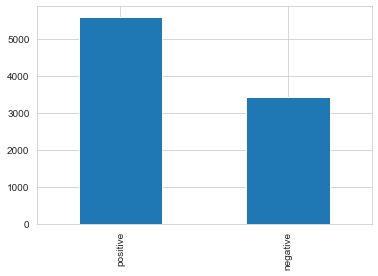

In [83]:
import matplotlib.pyplot as plt

df_text['log_reg'].value_counts().plot(kind="bar")